In [80]:
import ROOT
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import interpolate
from uncertainties import ufloat
from uncertainties.umath import *
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import copy
# Get all target polarizations from RCDB
import glob
import sys
sys.path.append("/work/clas12/users/gmat/packages/clas12root/rcdb/python/")
import rcdb
from rcdb.provider import RCDBProvider
from rcdb.model import ConditionType
ROOT.gErrorIgnoreLevel = ROOT.kError

In [18]:
def DF(A,nA,nMT,nCH,nC,nF,sA,sMT,sCH,sC,sF):
    
    nA=ufloat(nA,sA)
    nMT=ufloat(nMT,sMT)
    nCH=ufloat(nCH,sCH)
    nC=ufloat(nC,sC)
    nF=ufloat(nF,sF)
    
    lC=1.5
    L=5.86
    lCH=3
    rhoHe=0.145/4
    rhoC=2/12
    rhoCH=1/14
    rhoA=0
    if(A=="NH3"):
        rhoA=0.92/17
    elif(A=="ND3"):
        rhoA=0.92/20
    else:
        print("ERROR: In DF(), A must equal either NH3 or ND3...Aborting...")
        return -1
    
    numerator = 9*(nA-nMT)*rhoA*(lC*L*(-nCH+nMT)*rhoC+lC*lCH*(nF-nMT)*(rhoC-rhoCH)+lCH*L*(nC-nMT)*rhoCH)
    denominator = nA*(9*lC*L*(-nCH+nMT)*rhoA*rhoC+2*lCH*L*(nC-nMT)*rhoA*rhoCH+lC*lCH*(nF-nMT)*(9*rhoA*rhoC-2*(rhoA+3*rhoC)*rhoCH))
    return (numerator/denominator).n , (numerator/denominator).s

In [19]:
def get_files_in_range(directory, min_run, max_run):
    return_list = []
    for filename in os.listdir(directory):
        if filename.startswith('sidisdvcs'):
            run = filename.split('_')[1].split('.')[0]
            if int(run)==16404:
                continue # On 6/18/2024, this sidisdvcs run segfault when analyzing due to memory issue
                         # Don't worry, I'll fix this ~~someday~~
            if min_run <= int(run) <= max_run:
                return_list.append(os.path.join(directory, filename))
    return sorted(return_list, key=lambda x: int(x.split('_')[1].split('.')[0]))

def get_files(directory,runList):
    return_list = []
    for filename in os.listdir(directory):
        if filename.startswith('sidisdvcs'):
            run = filename.split('_')[1].split('.')[0]
            if run not in runList:
                continue
            return_list.append(os.path.join(directory, filename))
    return sorted(return_list, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [20]:
def sum_fcupgated(run):
    scaler_dir = "/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc-scalerpass1/run{}_HELScaler-all.csv".format(run)
    df_hel = pd.read_csv(scaler_dir)
    return df_hel.fcupgated_33ms.sum()

def get_total_fcupgated(runList):
    total = 0
    with ProcessPoolExecutor() as executor:
        # Wrap executor.map with tqdm for progress tracking
        results = list(tqdm(executor.map(sum_fcupgated, runList), total=len(runList), desc="Processing runs"))
    total = sum(results)
    return total

In [21]:
def get_rcdb(rootfiles):
    
    rcdb = pd.DataFrame()
    CookType = []
    Target = []
    Run = []
    Fcupgated = []
    for file in tqdm(rootfiles,desc="Running `get_rcdb()`"):
        tfile = ROOT.TFile(file,"READ")
        try:
            _target = tfile.Get("target")
            _run    = file.split('_')[1].split('.')[0]
            _fcup   = tfile.Get("fcup_pos")[0]+tfile.Get("fcup_neg")[0]+tfile.Get("fcup_zero")[0]
        except:
            continue
        
        Target.append(_target)
        Run.append(_run)
        Fcupgated.append(_fcup)
    rcdb["Target"]=Target
    rcdb["Run"]=Run
    rcdb["Fcupgated"]=Fcupgated
    return rcdb

In [61]:
def get_CD_scaling_factor(xmin,xmax,Q2min,Q2max):
    
    # Use Sebastian's hydrogen/deuteron ratios for N_CH
    # -----------------------------------------
    xc = np.round(0.5*(xmin+xmax),10)
    yc = np.round(0.5*(Q2min+Q2max),10)
    chcd=pd.read_csv("/work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-c/toolkit/CH_CD.csv",sep="\t")
    df1=chcd[chcd.x==xc]
    if(len(df1)==0):
        raise ValueError(xc,yc)
    df2=df1.iloc[(df1['Q2']-yc).abs().argsort()[:1]]
    factor=df2["CD2/CH2"].to_numpy()[0]
    return factor

In [50]:
# Function to process each file and fill a histogram
def fill_histogram(file_path, xbins, Q2bins):
    # Open the file and get the tree
    random_value = np.random.rand()
    tfile = ROOT.TFile(file_path,"READ")
    ttree = tfile.Get("events")
    hist = ROOT.TH2F(f"hist_{random_value}", "hist", len(xbins)-1, xbins, len(Q2bins)-1, Q2bins)
    ttree.Draw(f"Q2:x>>hist_{random_value}","","goff")
    # Return a deepcopy of the histogram
    return copy.deepcopy(hist)

# Function to combine histograms
def combine_histograms(hist_list):
    combined_hist = hist_list[0]
    for hist in hist_list[1:]:
        combined_hist.Add(hist)
    return combined_hist

# Process files in parallel and combine histograms
def process_files(files, xbins, Q2bins):
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(fill_histogram, files, [xbins]*len(files), [Q2bins]*len(files)), total=len(files), desc="Processing files"))
    
    # Combine the histograms
    combined_hist = combine_histograms(results)
    return combined_hist

In [44]:
# def extract_dilution_factors(rootdir="",
#                              debug=False):
    
#     # Get root files for analysis
#     rootfiles=get_files_in_range(directory, 0, 999999)
    
#     # Create rcdb dataframe
#     df_rcdb = get_rcdb(rootfiles)
#     df_rcdb=df_rcdb.sort_values(by="Run")
    
#     # Generate list of runs for the analysis
#     runList_NH3 = df_rcdb[df_rcdb.Target=="NH3"].Run.to_list()
#     runList_ND3 = df_rcdb[df_rcdb.Target=="ND3"].Run.to_list()
#     runList_C = df_rcdb[df_rcdb.Target=="C"].Run.to_list()
#     runList_CH = df_rcdb[df_rcdb.Target=="CH2"].Run.to_list()
#     runList_MT = df_rcdb[df_rcdb.Target=="Empty"].Run.to_list()
#     assert(runList_NH3!=[])
#     assert(runList_ND3!=[])
#     assert(runList_C!=[])
#     assert(runList_CH!=[])
#     assert(runList_MT!=[])
    
#     # Get files for each target type
#     files_NH3=get_files(rootdir,runList=runList_NH3)
#     files_ND3=get_files(rootdir,runList=runList_ND3)
#     files_C=get_files(rootdir,runList=runList_C)
#     files_CH=get_files(rootdir,runList=runList_CH)
#     files_MT=get_files(rootdir,runList=runList_MT)
    
#     # Generate RDataframes for each file list
#     df_NH3=0
#     # -----------------------------------------
#     if(debug):
#         df_NH3 = [ROOT.RDataFrame("events",f) for f in files_NH3]
#     else:
#         df_NH3 = ROOT.RDataFrame("events",files_NH3)
#     # -----------------------------------------
#     df_ND3 = ROOT.RDataFrame("events",files_ND3)
#     df_C = ROOT.RDataFrame("events",files_C)
#     df_CH = ROOT.RDataFrame("events",files_CH)
#     df_MT = ROOT.RDataFrame("events",files_MT)
    
#     # Get total fcupgated for each target
#     fcg_NH3=0
#     if(debug):
#         fcg_NH3=[get_total_fcupgated([r]) for r in runList_NH3]
#     else:
#         fcg_NH3 = get_total_fcupgated(runList_NH3); print("NH3 fcupgated calculated")
#     fcg_ND3 = get_total_fcupgated(runList_ND3); print("ND3 fcupgated calculated")
#     fcg_C = get_total_fcupgated(runList_C); print("C fcupgated calculated")
#     fcg_CH = get_total_fcupgated(runList_CH); print("CH fcupgated calculated")
#     fcg_MT = get_total_fcupgated(runList_MT); print("MT fcupgated calculated")
#     if(not debug):
#         assert(fcg_NH3>0)
#     assert(fcg_ND3>0)
#     assert(fcg_C>0)
#     assert(fcg_CH>0)
#     assert(fcg_MT>0)
    
#     # Get the x-Q2 binning based on Sebastian
#     df_seb = pd.read_csv("/work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-c/toolkit/sebastian_A_LL_p.txt",sep=" ",names=["xmin","xmax","Q2min","Q2max","A_LL"])
#     xbins = np.unique(np.array(df_seb["xmin"].to_list()+df_seb["xmax"].to_list()))
#     Q2bins = np.unique(np.array(df_seb["Q2min"].to_list()+df_seb["Q2max"].to_list()))
#     # for each possible x-Q2 binning, calculate the DF
#     cols=[]
#     # -----------------------------------------
#     if(debug):
#         cols=["xmin","xmax","Q2min","Q2max"]
#         for i in range(len(fcg_NH3)):
#             cols+=["df_NH3_{}".format(i),"df_err_NH3_{}".format(i)]
#         cols+=["df_ND3"]
#         for i in range(len(fcg_NH3)):
#             cols+=["N_NH3_{}".format(i)]
#         cols+=["N_ND3","N_C","N_CH","N_MT","N_F"]
#         for i in range(len(fcg_NH3)):
#             cols+=["fcupgated_NH3_{}".format(i)]
#         cols+=["fcupgated_ND3","fcupgated_C","fcupgated_CH","fcupgated_MT","fcupgated_F"]
#         for i in range(len(fcg_NH3)):
#             cols+=["n_NH3_{}".format(i)]
#         cols+=["n_ND3","n_C","n_CH","n_MT","n_F",cookType]
#     else:
#         cols=["xmin","xmax","Q2min","Q2max","df_NH3","df_err_NH3","df_ND3","df_err_ND3",
#                                    "N_NH3","N_ND3","N_C","N_CH","N_MT","N_F",
#                                    "fcupgated_NH3","fcupgated_ND3","fcupgated_C","fcupgated_CH","fcupgated_MT","fcupgated_F",
#                                    "n_NH3","n_ND3","n_C","n_CH","n_MT","n_F",
#                                    "cookType"]
#     # -----------------------------------------
#     df_out = pd.DataFrame(columns=cols)
    
#     h_NH3=0
#     # -----------------------------------------
#     if(debug):
#         h_NH3 = [d.Histo2D(("h_NH3","h_NH3",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2") for d in df_NH3]
#     else:
#         h_NH3 = df_NH3.Histo2D(("h_NH3","h_NH3",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2")
#     # -----------------------------------------
#     h_ND3 = df_ND3.Histo2D(("h_ND3","h_ND3",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2")
#     h_C = df_C.Histo2D(("h_C","h_C",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2")
#     h_CH = df_CH.Histo2D(("h_CH","h_CH",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2")
#     h_MT = df_MT.Histo2D(("h_MT","h_MT",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins),"x","Q2")
#     for i in range(len(xbins)-1):
#         for j in range(len(Q2bins)-1):
#             xmin=xbins[i]
#             xmax=xbins[i+1]
#             Q2min=Q2bins[j]
#             Q2max=Q2bins[j+1]
            
#             # -----------------------------------------
#             N_NH3=0
#             if(debug):
#                 N_NH3 = [h.GetBinContent(h.GetBin(i+1,j+1)) for h in h_NH3]
#             else:
#                 N_NH3 = h_NH3.GetBinContent(h_NH3.GetBin(i+1,j+1))
#             N_ND3 = h_ND3.GetBinContent(h_ND3.GetBin(i+1,j+1))
            
            
#             N_C = h_C.GetBinContent(h_C.GetBin(i+1,j+1))
#             N_CH = h_CH.GetBinContent(h_CH.GetBin(i+1,j+1))
#             # DEBUG AS OFF 10/29/2022
#             # Use Sebastian's hydrogen/deuteron ratios for N_CH
#             # -----------------------------------------
#             xc = 0.5*(xmin+xmax)
#             yc = 0.5*(Q2min+Q2max)
#             chcd=pd.read_csv("/work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-c/toolkit/CH_CD.csv",sep="\t")
#             df1=chcd[chcd.x==xc]
#             if(len(df1)==0):
#                 continue
#             df2=df1.iloc[(df1['Q2']-yc).abs().argsort()[:1]]
#             factor=df2["CD2/CH2"].to_numpy()[0]
#             N_CD = N_CH*factor
#             # -----------------------------------------
        
#             N_MT = h_MT.GetBinContent(h_MT.GetBin(i+1,j+1))
#             # -----------------------------------------
            
#             if(N_NH3==0 or N_ND3==0 or N_C==0 or N_CH==0 or N_MT==0):
#                 continue
            
#             # -----------------------------------------
#             n_NH3=0
#             if(debug):
#                 n_NH3 = [N/fcg for N,fcg in zip(N_NH3,fcg_NH3)]
#             else:
#                 n_NH3 = N_NH3/fcg_NH3
#             n_ND3 = N_ND3/fcg_ND3
#             n_C = N_C/fcg_C
#             n_CH = N_CH/fcg_CH
#             n_CD = N_CD/fcg_CH # DEBUG 10/29/2022 not sure what fcg to use
#             n_MT = N_MT/fcg_MT
            
#             s_nH3=0
#             if(debug):
#                 s_NH3 = [np.sqrt(N)/fcg for N,fcg in zip(N_NH3,fcg_NH3)]
#             else:
#                 s_NH3 = np.sqrt(N_NH3)/fcg_NH3
#             s_ND3 = np.sqrt(N_ND3)/fcg_ND3
#             s_C = np.sqrt(N_C)/fcg_C
#             s_CH = np.sqrt(N_CH)/fcg_CH
#             s_CD = np.sqrt(N_CD)/fcg_CH
#             s_MT = np.sqrt(N_MT)/fcg_MT
            
#             # -----------------------------------------
            
#             # -----------------------------------------
#             dilution_NH3=0
#             if(debug):
#                 dilution_NH3,dilution_err_NH3 = np.array([DF("NH3",n,n_MT,n_CH,n_C,0,s,s_MT,s_CH,s_C,0) for n,s in zip(n_NH3,s_NH3)]).transpose()
#             else:
#                 dilution_NH3,dilution_err_NH3 = DF("NH3",n_NH3,n_MT,n_CH,n_C,0,s_NH3,s_MT,s_CH,s_C,0)
                
            
#             #dilution_ND3,dilution_err_ND3 = DF("ND3",n_ND3,n_MT,n_CH,n_C,0,s_ND3,s_MT,s_CH,s_C,0)
#             # DEBUG 10/29/2022
#             # Using N_CD
#             dilution_ND3,dilution_err_ND3 = DF("ND3",n_ND3,n_MT,n_CD,n_C,0,s_ND3,s_MT,s_CD,s_C,0)
#             # -----------------------------------------
            
#             # -----------------------------------------
#             row=0
#             if(debug):
#                 row = [xmin,xmax,Q2min,Q2max]
#                 for d,de in zip(dilution_NH3,dilution_err_NH3):
#                     row+=[d,de]
#                 row+=[dilution_ND3]
#                 row+=[N for N in N_NH3]
#                 row+=[N_ND3,N_C,N_CH,N_MT,0]
#                 row+=[fcg for fcg in fcg_NH3]
#                 row+=[fcg_ND3,fcg_C,fcg_CH,fcg_MT,0]
#                 row+=[n for n in n_NH3]
#                 row+=[n_ND3,n_C,n_CH,n_MT,0,cookType]
#             else:
#                 row = [xmin,xmax,Q2min,Q2max,dilution_NH3,dilution_err_NH3,dilution_ND3,dilution_err_ND3,
#                        N_NH3,N_ND3,N_C,N_CH,N_MT,0,
#                        fcg_NH3,fcg_ND3,fcg_C,fcg_CH,fcg_MT,0,
#                        n_NH3,n_ND3,n_C,n_CH,n_MT,0,cookType]
#             # -----------------------------------------
#             df_out.loc[len(df_out.index)] = row
            
#     print("NH3 Runs:",runList_NH3)
#     print("ND3 Runs:",runList_ND3)
#     print("C Runs:",runList_C)
#     print("CH Runs:",runList_CH)
#     print("MT Runs:",runList_MT)
#     return df_out

In [51]:
###################################################################################
# READ
# As of 6/18/2024 we do not have CD2 target data (Summer2022)
# We comment lines involving CD2 targets and include a factor for scaling yields
#################################################################################

rootdir="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/"

# Get root files for analysis
rootfiles=get_files_in_range(rootdir, 0, 999999)

# Create rcdb dataframe
df_rcdb = get_rcdb(rootfiles)
df_rcdb=df_rcdb.sort_values(by="Run")

# Generate list of runs for the analysis
runList_NH3 = df_rcdb[df_rcdb.Target=="NH3"].Run.to_list()
runList_ND3 = df_rcdb[df_rcdb.Target=="ND3"].Run.to_list()
runList_C = df_rcdb[df_rcdb.Target=="C"].Run.to_list()
runList_CH = df_rcdb[df_rcdb.Target=="CH2"].Run.to_list()
#runList_CD = df_rcdb[df_rcdb.Target=="CD2"].Run.to_list()
runList_MT = df_rcdb[df_rcdb.Target=="Empty"].Run.to_list()
assert(runList_NH3!=[])
assert(runList_ND3!=[])
assert(runList_C!=[])
assert(runList_CH!=[])
#assert(runList_CD!=[])
assert(runList_MT!=[])

# Get files for each target type
files_NH3=get_files(rootdir,runList=runList_NH3)
files_ND3=get_files(rootdir,runList=runList_ND3)
files_C=get_files(rootdir,runList=runList_C)
files_CH=get_files(rootdir,runList=runList_CH)
#files_CD=get_files(rootdir,runList=runList_CD)
files_MT=get_files(rootdir,runList=runList_MT)

Running `get_rcdb()`: 100%|██████████████████| 358/358 [00:20<00:00, 17.17it/s]


In [25]:
# Get total fcupgated for each target
fcg_NH3 = get_total_fcupgated(runList_NH3); print("NH3 fcupgated calculated")
fcg_ND3 = get_total_fcupgated(runList_ND3); print("ND3 fcupgated calculated")
fcg_C = get_total_fcupgated(runList_C); print("C fcupgated calculated")
fcg_CH = get_total_fcupgated(runList_CH); print("CH fcupgated calculated")
#fcg_CD = get_total_fcupgated(runList_CD); print("CD fcupgated calculated")
fcg_CD = fcg_CH
fcg_MT = get_total_fcupgated(runList_MT); print("MT fcupgated calculated")
assert(fcg_NH3>0)
assert(fcg_ND3>0)
assert(fcg_C>0)
assert(fcg_CH>0)
#assert(fcg_CD>0)
assert(fcg_MT>0)

Processing runs: 100%|███████████████████████| 158/158 [00:07<00:00, 22.02it/s]

NH3 fcupgated calculated



Processing runs: 100%|███████████████████████| 149/149 [00:06<00:00, 23.58it/s]


ND3 fcupgated calculated


Processing runs: 100%|█████████████████████████| 36/36 [00:01<00:00, 33.96it/s]

C fcupgated calculated



Processing runs: 100%|███████████████████████████| 6/6 [00:00<00:00,  8.29it/s]

CH fcupgated calculated



Processing runs: 100%|███████████████████████████| 8/8 [00:01<00:00,  6.20it/s]

MT fcupgated calculated


In [52]:
# Get the x-Q2 binning based on Sebastian
df_seb = pd.read_csv("/work/clas12/users/gmat/CLAS12Analysis/macros/analysis/rg-c/toolkit/sebastian_A_LL_p.txt",sep=" ",names=["xmin","xmax","Q2min","Q2max","A_LL"])
xbins = np.unique(np.array(df_seb["xmin"].to_list()+df_seb["xmax"].to_list()))
Q2bins = np.unique(np.array(df_seb["Q2min"].to_list()+df_seb["Q2max"].to_list()))
# for each possible x-Q2 binning, calculate the DF
cols=["xmin","xmax","Q2min","Q2max","df_NH3","df_err_NH3","df_ND3","df_err_ND3",
                           "N_NH3","N_ND3","N_C","N_CH","N_CD","N_MT","N_F",
                           "fcupgated_NH3","fcupgated_ND3","fcupgated_C","fcupgated_CH","fcupgated_CD","fcupgated_MT","fcupgated_F",
                           "n_NH3","n_ND3","n_C","n_CH","n_CD","n_MT","n_F"]

h_NH3 = process_files(files_NH3, xbins, Q2bins)
h_ND3 = process_files(files_ND3, xbins, Q2bins)
h_C = process_files(files_C, xbins, Q2bins)
h_CH = process_files(files_CH, xbins, Q2bins)
#h_CD = process_files(files_CD, xbins, Q2bins)
h_MT = process_files(files_MT, xbins, Q2bins)

In [70]:
df = pd.DataFrame(columns=cols)
for i in range(len(xbins)-1):
    for j in range(len(Q2bins)-1):
        xmin=xbins[i]
        xmax=xbins[i+1]
        Q2min=Q2bins[j]
        Q2max=Q2bins[j+1]

        N_NH3 = h_NH3.GetBinContent(h_NH3.GetBin(i+1,j+1))
        N_ND3 = h_ND3.GetBinContent(h_ND3.GetBin(i+1,j+1))
        N_C = h_C.GetBinContent(h_C.GetBin(i+1,j+1))
        N_CH = h_CH.GetBinContent(h_CH.GetBin(i+1,j+1))
        #N_CD = h_CH.GetBinContent(h_CD.GetBin(i+1,j+1))
        N_CD = N_CH * get_CD_scaling_factor(xmin,xmax,Q2min,Q2max)
        N_MT = h_MT.GetBinContent(h_MT.GetBin(i+1,j+1))

        if(N_NH3==0 or N_ND3==0 or N_C==0 or N_CH==0 or N_CD==0 or N_MT==0):
            continue

        n_NH3 = N_NH3/fcg_NH3
        n_ND3 = N_ND3/fcg_ND3
        n_C = N_C/fcg_C
        n_CH = N_CH/fcg_CH
        n_CD = N_CD/fcg_CD 
        n_MT = N_MT/fcg_MT

        s_NH3 = np.sqrt(N_NH3)/fcg_NH3
        s_ND3 = np.sqrt(N_ND3)/fcg_ND3
        s_C = np.sqrt(N_C)/fcg_C
        s_CH = np.sqrt(N_CH)/fcg_CH
        s_CD = np.sqrt(N_CD)/fcg_CD
        s_MT = np.sqrt(N_MT)/fcg_MT

        dilution_NH3,dilution_err_NH3 = DF("NH3",n_NH3,n_MT,n_CH,n_C,0,s_NH3,s_MT,s_CH,s_C,0)
        dilution_ND3,dilution_err_ND3 = DF("ND3",n_ND3,n_MT,n_CD,n_C,0,s_ND3,s_MT,s_CD,s_C,0)
        # -----------------------------------------
        row = [xmin,xmax,Q2min,Q2max,dilution_NH3,dilution_err_NH3,dilution_ND3,dilution_err_ND3,
               N_NH3,N_ND3,N_C,N_CH,N_CD,N_MT,0,
               fcg_NH3,fcg_ND3,fcg_C,fcg_CH,fcg_CD,fcg_MT,0,
               n_NH3,n_ND3,n_C,n_CH,n_CD,n_MT,0]
        # -----------------------------------------
        df.loc[len(df.index)] = row
        
print("DataFrame created...")
print(df.columns)
display(df)
df.to_csv("rg")

DataFrame created...
Index(['xmin', 'xmax', 'Q2min', 'Q2max', 'df_NH3', 'df_err_NH3', 'df_ND3',
       'df_err_ND3', 'N_NH3', 'N_ND3', 'N_C', 'N_CH', 'N_CD', 'N_MT', 'N_F',
       'fcupgated_NH3', 'fcupgated_ND3', 'fcupgated_C', 'fcupgated_CH',
       'fcupgated_CD', 'fcupgated_MT', 'fcupgated_F', 'n_NH3', 'n_ND3', 'n_C',
       'n_CH', 'n_CD', 'n_MT', 'n_F'],
      dtype='object')


,xmin,xmax,Q2min,Q2max,df_NH3,df_err_NH3,df_ND3,df_err_ND3,N_NH3,N_ND3,...,fcupgated_CD,fcupgated_MT,fcupgated_F,n_NH3,n_ND3,n_C,n_CH,n_CD,n_MT,n_F
0,0.10,0.15,0.9188,1.0969,0.251697,0.012635,0.334755,0.009970,90103.0,68786.0,...,139172.334485,1.300651e+06,0.0,0.020622,0.018106,0.036530,0.039749,0.044718,0.002415,0.0
1,0.10,0.15,1.0969,1.3094,0.105249,0.002858,0.225814,0.002284,5628709.0,5275471.0,...,139172.334485,1.300651e+06,0.0,1.288244,1.388634,1.499450,1.390255,1.562646,0.078737,0.0
2,0.10,0.15,1.3094,1.5632,0.127121,0.001252,0.243851,0.001002,26487550.0,24670468.0,...,139172.334485,1.300651e+06,0.0,6.062213,6.493877,7.189215,6.803744,7.647409,0.361644,0.0
3,0.10,0.15,1.5632,1.8661,0.120903,0.001097,0.238683,0.000878,35289108.0,32925956.0,...,139172.334485,1.300651e+06,0.0,8.076628,8.666925,9.592186,9.029697,10.149379,0.458129,0.0
4,0.10,0.15,1.8661,2.2277,0.118816,0.001505,0.237728,0.001203,18864964.0,17580052.0,...,139172.334485,1.300651e+06,0.0,4.317630,4.627504,5.135104,4.825794,5.429018,0.238635,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.65,0.70,6.4475,7.6969,0.126120,0.026617,0.211322,0.022735,62640.0,57116.0,...,139172.334485,1.300651e+06,0.0,0.014336,0.015034,0.016081,0.015175,0.016481,0.000948,0.0
80,0.65,0.70,7.6969,9.1884,0.130253,0.019433,0.216699,0.016539,116900.0,106240.0,...,139172.334485,1.300651e+06,0.0,0.026755,0.027965,0.029746,0.028181,0.030661,0.001731,0.0
81,0.65,0.70,9.1884,10.9689,0.116711,0.028239,0.203660,0.024047,56917.0,51221.0,...,139172.334485,1.300651e+06,0.0,0.013027,0.013483,0.014777,0.013832,0.015035,0.000837,0.0
82,0.70,0.75,7.6969,9.1884,0.244876,0.076701,0.316465,0.066263,4985.0,4743.0,...,139172.334485,1.300651e+06,0.0,0.001141,0.001248,0.001214,0.001293,0.001403,0.000064,0.0


# Figure 1: x-Q2 binned dilution factors

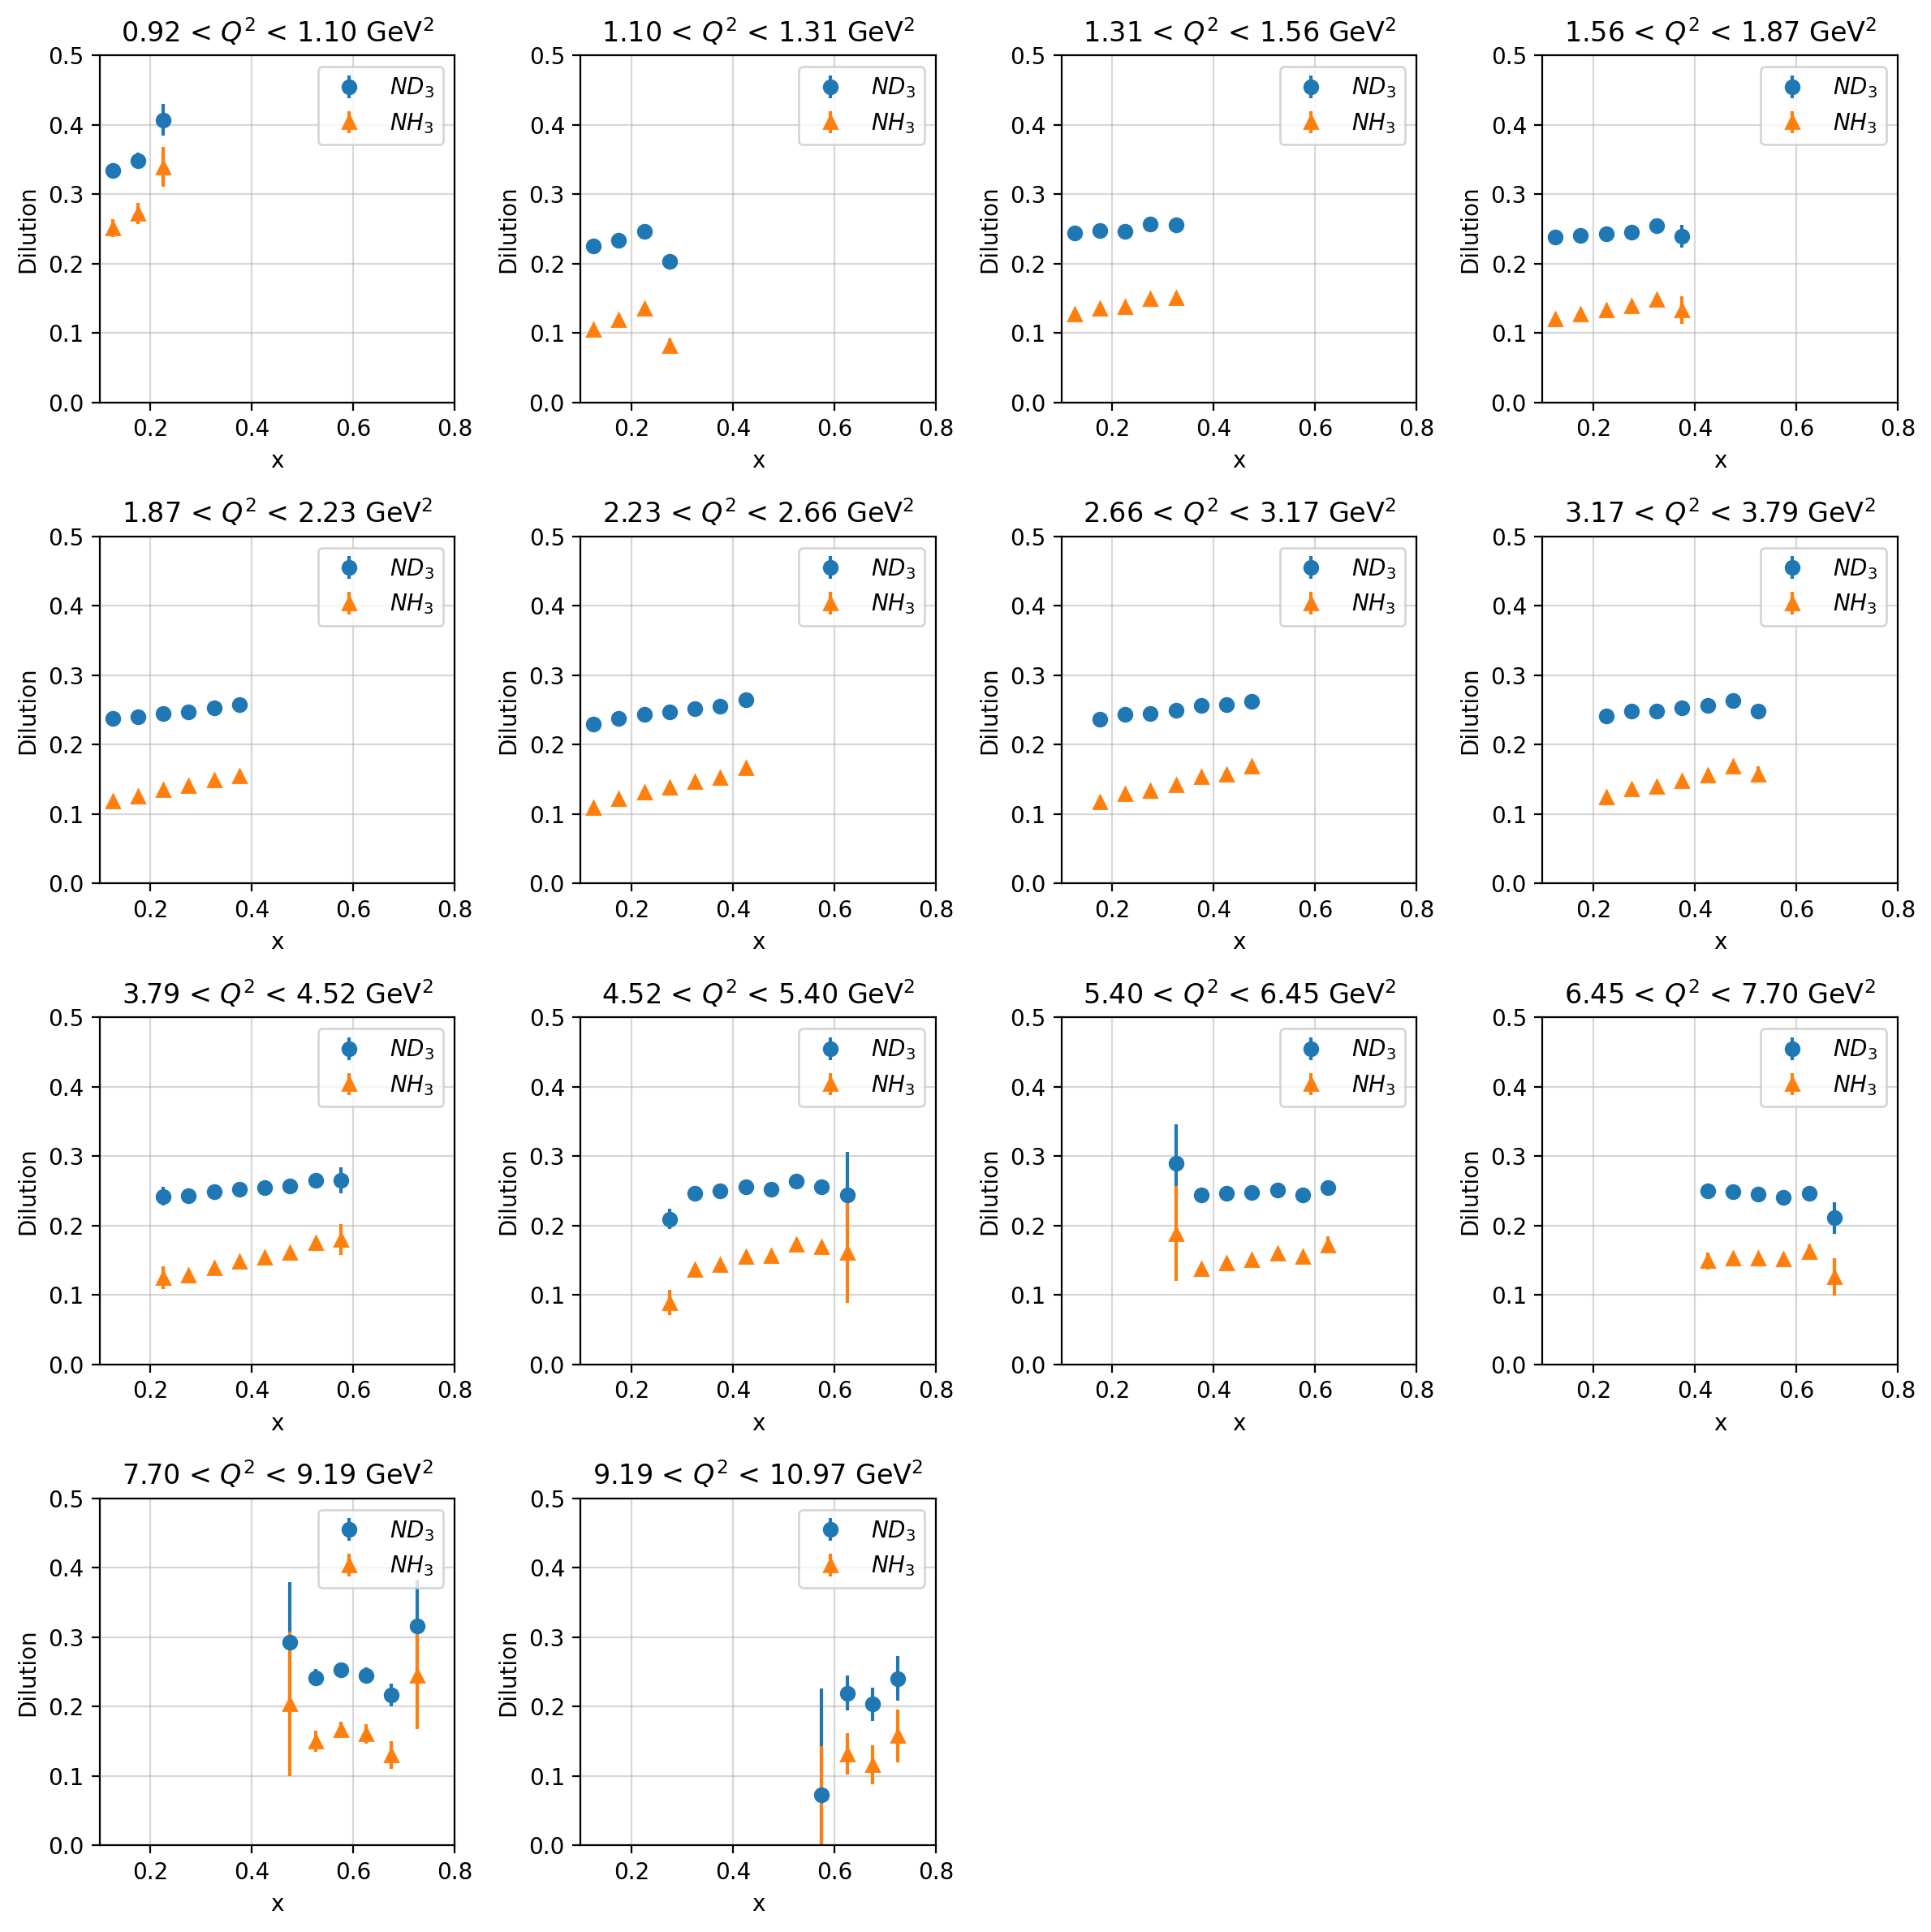

In [93]:

# Determine unique combinations of Q2min and Q2max
unique_combinations = df[['Q2min', 'Q2max']].drop_duplicates()

nplots = len(unique_combinations)
nrows = 4
ncols = int(np.ceil(nplots / nrows))

fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), dpi=200)

# Ensure axs is a 2D array
axs = axs.reshape(nrows, ncols)

for idx, (Q2min, Q2max) in enumerate(unique_combinations.values):
    # Select the subplot
    ax = axs[idx // ncols, idx % ncols]
    
    # Filter the dataframe for the current Q2 range
    df_filtered = df[(df['Q2min'] == Q2min) & (df['Q2max'] == Q2max)]
    
    # Calculate <x> as the mean of xmin and xmax
    x_mean = (df_filtered['xmin'] + df_filtered['xmax']) / 2
    
    # Plot dilution factors vs. <x>
    ax.errorbar(x_mean, df_filtered['df_ND3'], yerr=df_filtered['df_err_ND3'], fmt='o', label='$ND_{3}$')
    ax.errorbar(x_mean, df_filtered['df_NH3'], yerr=df_filtered['df_err_NH3'], fmt='^', label='$NH_{3}$')

    
    # Set plot title and labels
    ax.set_title(f'{Q2min:.2f} < $Q^{{2}}$ < {Q2max:.2f} GeV$^{{2}}$')
    ax.set_xlabel('x')
    ax.set_ylabel('Dilution')
    ax.set_xlim(0.1,0.8)
    ax.set_ylim(0,0.5)
    ax.grid('xy',alpha=0.5)
    ax.legend()

# Hide any unused subplots
for i in range(nplots, nrows * ncols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()